In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# We will visualize the messages with a word cloud
from wordcloud import WordCloud

# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Import Tf-idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder

# Import the train test split
from sklearn.model_selection import train_test_split

# To evaluate our model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# I will keep the resulting plots
%matplotlib inline

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

In [3]:
# Load the data
data = pd.read_csv('train.csv')

In [4]:
# Display firt five rows
display(data.head())

# Display the summary statistics
display(data.describe())

# Print the info
print(data.info())

,Unnamed: 0,title,text,subject,date,label
0,0,"Trump Attacks The ‘Failing’ New York Times, B...",Donald Trump kicked off his Sunday morning by ...,News,"February 26, 2017",0
1,1,LOL! AMAZON USERS WRITE GUT-BUSTING Reviews Fo...,The extremely exhausted Hillary and her extrem...,politics,"Sep 21, 2016",0
2,2,Kentucky governor sues to close abortion clinic,(Reuters) - Kentucky’s Republican Governor Mat...,politicsNews,"March 3, 2016",1
3,3,Hezbollah calls on Saudi Arabia to cease inter...,BEIRUT (Reuters) - Hezbollah s parliamentary b...,worldnews,"November 9, 2017",1
4,4,George Takei Just Shook Washington To Its Cor...,"By now, we all know that House Intelligence Co...",News,"April 1, 2017",0


,Unnamed: 0,label
count,13469.000000,13469.000000
mean,6734.000000,0.479620
std,3888.309723,0.499603
min,0.000000,0.000000
25%,3367.000000,0.000000
50%,6734.000000,0.000000
75%,10101.000000,1.000000
max,13468.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13469 entries, 0 to 13468
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13469 non-null  int64 
 1   title       13469 non-null  object
 2   text        13469 non-null  object
 3   subject     13469 non-null  object
 4   date        13469 non-null  object
 5   label       13469 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 631.5+ KB
None


label
0    426.431160
1    385.383746
Name: word_count, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


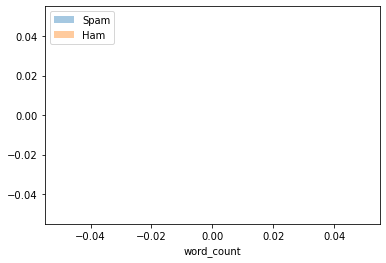

In [5]:
# Store the number of words in each messages
data['word_count'] = data['text'].str.split().str.len()

# Print the average number of words in each category
print(data.groupby('label')['word_count'].mean())

# Visualize the distribution of word counts in each category
sns.distplot(data[data['label']=='spam']['word_count'], label='Spam')
sns.distplot(data[data['label']=='ham']['word_count'], label='Ham'),
plt.legend()
plt.show()

In [6]:
# Make the letters lower case and tokenize the words
tokenized_texts = data['text'].str.lower().apply(word_tokenize)

# Print the tokens to see how it looks like
print(tokenized_texts)

0        [donald, trump, kicked, off, his, sunday, morn...
1        [the, extremely, exhausted, hillary, and, her,...
2        [(, reuters, ), -, kentucky, ’, s, republican,...
3        [beirut, (, reuters, ), -, hezbollah, s, parli...
4        [by, now, ,, we, all, know, that, house, intel...
                               ...                        
13464    [civil, rights, icon, ,, rep., john, lewis, ,,...
13465    [washington, (, reuters, ), -, about, 60, smal...
13466    [moscow, (, reuters, ), -, carter, page, ,, a,...
13467    [but, wait, the, first, female, president, oh,...
13468    [facebook, is, in, the, middle, of, a, charm, ...
Name: text, Length: 13469, dtype: object


In [7]:
# Define a function to returns only alphanumeric tokens
def alpha(tokens):
    """This function removes all non-alphanumeric characters"""
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

# Apply our function to tokens
tokenized_texts = tokenized_texts.apply(alpha)

print(tokenized_texts)

0        [donald, trump, kicked, off, his, sunday, morn...
1        [the, extremely, exhausted, hillary, and, her,...
2        [reuters, kentucky, s, republican, governor, m...
3        [beirut, reuters, hezbollah, s, parliamentary,...
4        [by, now, we, all, know, that, house, intellig...
                               ...                        
13464    [civil, rights, icon, john, lewis, recently, a...
13465    [washington, reuters, about, small, business, ...
13466    [moscow, reuters, carter, page, a, businessman...
13467    [but, wait, the, first, female, president, oh,...
13468    [facebook, is, in, the, middle, of, a, charm, ...
Name: text, Length: 13469, dtype: object


In [8]:
# Define a function to remove stop words
def remove_stop_words(tokens):
    """This function removes all stop words in terms of nltk stopwords"""
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

# Apply our function to tokens
tokenized_texts = tokenized_texts.apply(remove_stop_words)

print(tokenized_texts)

KeyboardInterrupt: 

In [ ]:
# Define a function to lemmatization
def lemmatize(tokens):
    """This function lemmatize the messages"""
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# Apply our function to tokens
tokenized_texts = tokenized_texts.apply(lemmatize)

print(tokenized_texts)

In [ ]:
# Replace the columns with tokenized messages
data['text'] = tokenized_texts

# Display the first five rows
display(data.head())

In [ ]:
# Select the features and the target
X = data['text']
y = data['label']



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)
X_train

In [ ]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)



In [ ]:
# Initialize the Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
print("Accuracy:",nb.score(tfidf_test, y_test))

In [ ]:
# Predict the labels
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)


# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:",auc_score)

# Get probabilities.
y_pred_proba = nb.predict(tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Visualize the ROC curve.
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.show()

https://www.kaggle.com/barishasdemir/classification-with-naive-bayes